Matched leptonJet _vs_ misreconstruction

In [38]:
import os
import numpy as np
import awkward
import matplotlib.pyplot as plt
import utils.histoHelpers as uhh

plt.style.use('default')
plt.rcParams.update(uhh.ffPltStyleSettings)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sigdataset_ = awkward.load(os.path.join(os.environ['FFANA_BASE'], 'mvatrain/data/signal_v6.awkd'))

In [17]:
sigdataset = np.column_stack([sigdataset_[k] for k in sigdataset_ if k !='match'])
target = sigdataset_['match']

In [18]:
print(sigdataset.shape)
print(target.shape)

(1372039, 14)
(1372039,)


In [16]:
list(sigdataset_.keys())

['match',
 'pt',
 'eta',
 'neufrac',
 'maxd0',
 'mind0',
 'tkiso',
 'pfiso',
 'spreadpt',
 'spreaddr',
 'lambda',
 'epsilon',
 'ecf1',
 'ecf2',
 'ecf3']

In [19]:
from sklearn.model_selection import train_test_split

X_trainVal, X_test, y_trainVal, y_test = train_test_split(sigdataset, target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, random_state=49)

In [69]:
import xgboost

xgb_clf = xgboost.XGBClassifier(n_estimators=200, n_jobs=12, learning_rate=0.3)
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=5,
    eval_metric='logloss',
)
y_pred = xgb_clf.predict(X_val)

[0]	validation_0-logloss:0.462855	validation_1-logloss:0.462784
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.334824	validation_1-logloss:0.334911
[2]	validation_0-logloss:0.254411	validation_1-logloss:0.254637
[3]	validation_0-logloss:0.200534	validation_1-logloss:0.200813
[4]	validation_0-logloss:0.164	validation_1-logloss:0.16449
[5]	validation_0-logloss:0.138405	validation_1-logloss:0.138858
[6]	validation_0-logloss:0.120285	validation_1-logloss:0.1207
[7]	validation_0-logloss:0.106938	validation_1-logloss:0.107425
[8]	validation_0-logloss:0.097398	validation_1-logloss:0.098034
[9]	validation_0-logloss:0.090724	validation_1-logloss:0.091377
[10]	validation_0-logloss:0.086054	validation_1-logloss:0.086778
[11]	validation_0-logloss:0.082246	validation_1-logloss:0.08299
[12]	validation_0-logloss:0.079709	validation_1-logloss:0.080476
[13]	val

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9805681455970271

In [71]:
for name, val in zip(list(sigdataset_.keys())[1:], xgb_clf.feature_importances_):
    print('{:>10} {:.4f}'.format(name, val))

        pt 0.1223
       eta 0.0030
   neufrac 0.0751
     maxd0 0.0182
     mind0 0.0232
     tkiso 0.0211
     pfiso 0.6895
  spreadpt 0.0099
  spreaddr 0.0050
    lambda 0.0005
   epsilon 0.0021
      ecf1 0.0246
      ecf2 0.0041
      ecf3 0.0014


In [72]:
accuracy_score(y_test, xgb_clf.predict(X_test))

0.9810821841928806

In [73]:
y_score = xgb_clf.predict_proba(X_test)[:,1]

In [74]:
y_score

array([0.00194406, 0.00534623, 0.00206947, ..., 0.9992718 , 0.0025282 ,
       0.00205053], dtype=float32)

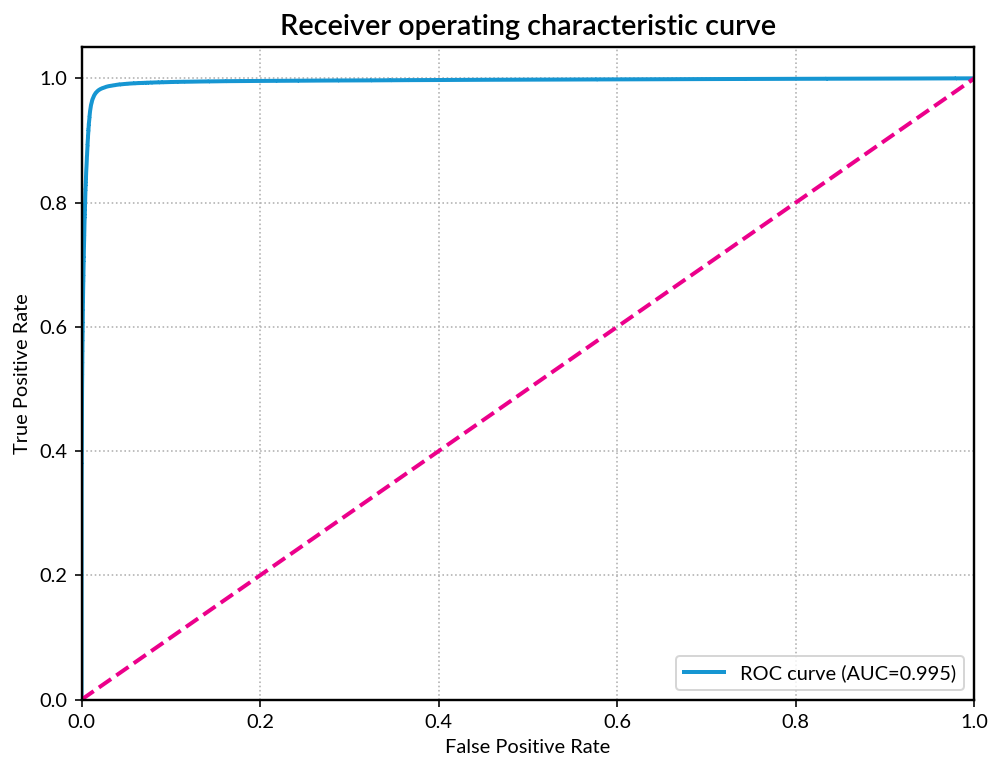

In [103]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC={:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right");

In [98]:
tpr[:20]

array([0.00000000e+00, 7.39579327e-06, 6.65621395e-05, 8.13537260e-05,
       1.33124279e-04, 1.47915865e-04, 2.29269591e-04, 2.44061178e-04,
       2.58852765e-04, 2.88435938e-04, 3.03227524e-04, 3.18019111e-04,
       3.77185457e-04, 3.99372837e-04, 4.28956010e-04, 4.51143390e-04,
       4.88122356e-04, 5.02913943e-04, 5.17705529e-04, 5.32497116e-04])

In [76]:
losses = xgb_clf.evals_result_
bst_n_estimators0 = np.argmin(losses['validation_0']['logloss'])
bst_n_estimators1 = np.argmin(losses['validation_1']['logloss'])
min_losses0 = np.min(losses['validation_0']['logloss'])
min_losses1 = np.min(losses['validation_1']['logloss'])

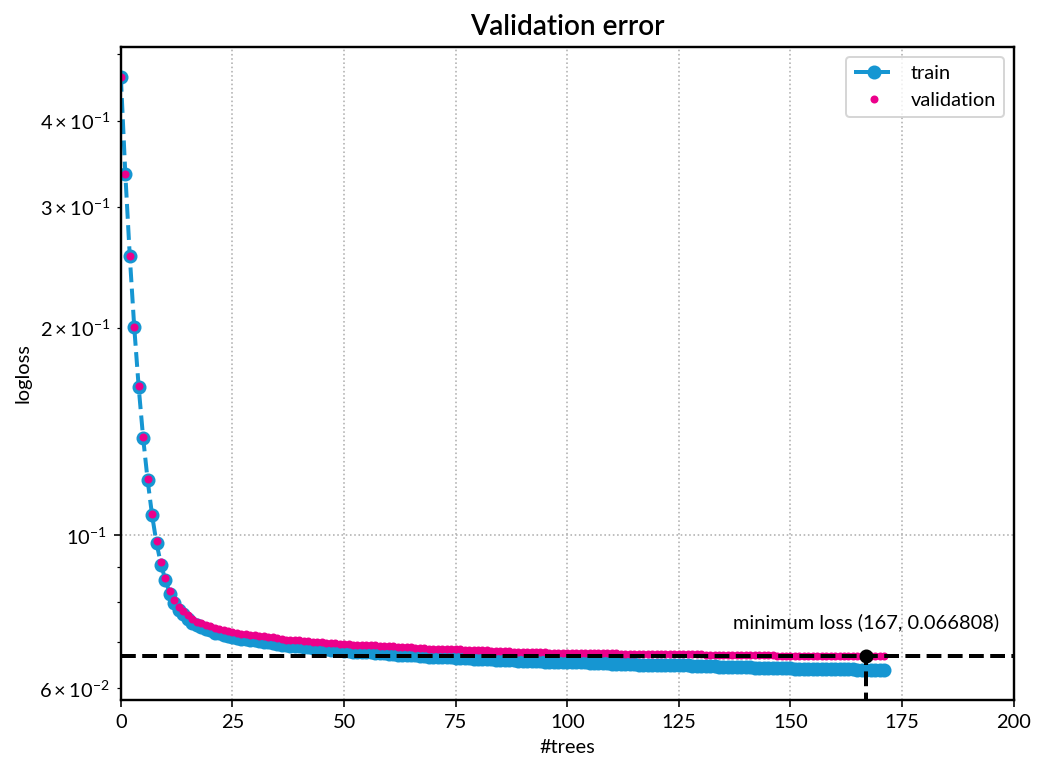

In [89]:
plt.figure(figsize=(8,6))
plt.plot(losses['validation_0']['logloss'], 'o--', label='train')
plt.plot(losses['validation_1']['logloss'], '.', label='validation')

plt.plot([bst_n_estimators1, bst_n_estimators1], [0, min_losses1], 'k--')
plt.plot([0, 200], [min_losses1, min_losses1], 'k--')
plt.plot(bst_n_estimators1, min_losses1, 'ko')
plt.text(bst_n_estimators1, min_losses1*1.1, f"minimum loss ({bst_n_estimators1}, {min_losses1})", ha='center')

# plt.axis([0, 200, 0, 0.5])
plt.xlabel("#trees")
plt.ylabel("logloss")
plt.yscale('log')
plt.xlim([0, 200])
plt.title("Validation error", fontsize=14)
plt.legend();

In [80]:
bst_n_estimators1

167